<a href="https://colab.research.google.com/github/ArthurVarteressians/FASHION-MNIST/blob/master/FASHION_MNIST.version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#import time

In [2]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST', train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor()]))

test_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor()]))

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
test_set

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data/FashionMNIST
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [4]:
train_set

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data/FashionMNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [5]:
train_loader = torch.utils.data.DataLoader(train_set)
print(train_loader)

In [6]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(test_set, batch_size = 64, shuffle = True)

In [7]:
# Examine a sample
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


tensor(7)


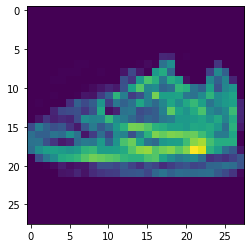

In [8]:
i = 85
print(train_loader.dataset.targets[i])
plt.imshow(train_loader.dataset.data[i])# Or, cmap = "gray")

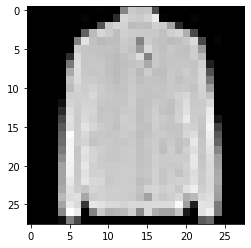

In [9]:
plt.imshow(images[52].numpy().squeeze(), cmap = 'gray')

In [10]:
(np.where(train_loader.dataset.targets==1)[0]).shape

(6000,)

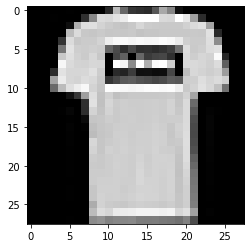

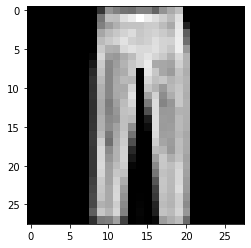

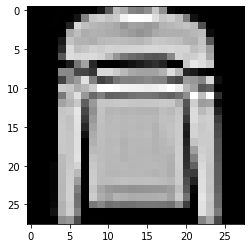

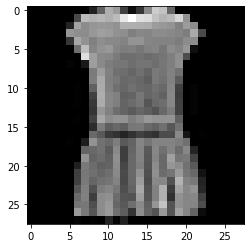

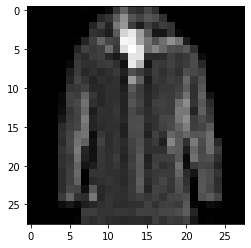

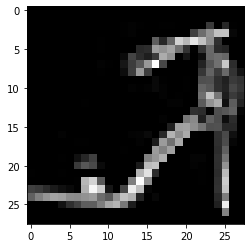

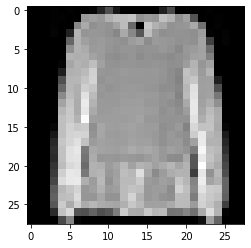

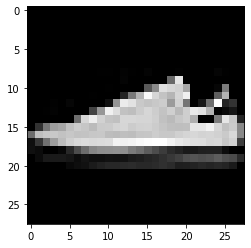

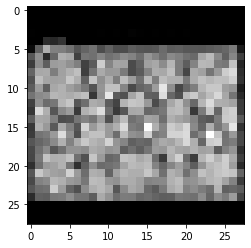

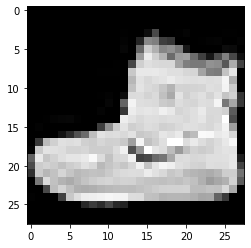

In [11]:
for i in range(10):
  ind = np.where(train_loader.dataset.targets==i)[0][0]
  plt.imshow(train_loader.dataset.data[ind], cmap = "gray")
  plt.show()

In [12]:
from torch import nn, optim

model = nn.Sequential(nn.Linear(784, 256),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim = 1)
                     )

# Define the loss 
criterion = nn.NLLLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.002)

epochs = 10

train_losses, test_losses = [], []

for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    images = images.view(images.shape[0], -1)
    
    optimizer.zero_grad()
    
    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    
    with torch.no_grad():
      # Set the model to evaluation mode
      model.eval()
      
      # Validation pass
      for images, labels in testloader:
        images = images.view(images.shape[0], -1)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/5.. Training loss: 0.592.. Test loss: 0.452.. Test Accuracy: 0.836
Epoch: 2/5.. Training loss: 0.430.. Test loss: 0.395.. Test Accuracy: 0.861
Epoch: 3/5.. Training loss: 0.395.. Test loss: 0.378.. Test Accuracy: 0.865
Epoch: 4/5.. Training loss: 0.376.. Test loss: 0.393.. Test Accuracy: 0.858
Epoch: 5/5.. Training loss: 0.363.. Test loss: 0.386.. Test Accuracy: 0.855


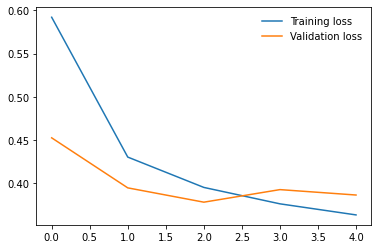

In [13]:
plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Validation loss")
plt.legend(frameon = False)

In [16]:
# Define view_classify function
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

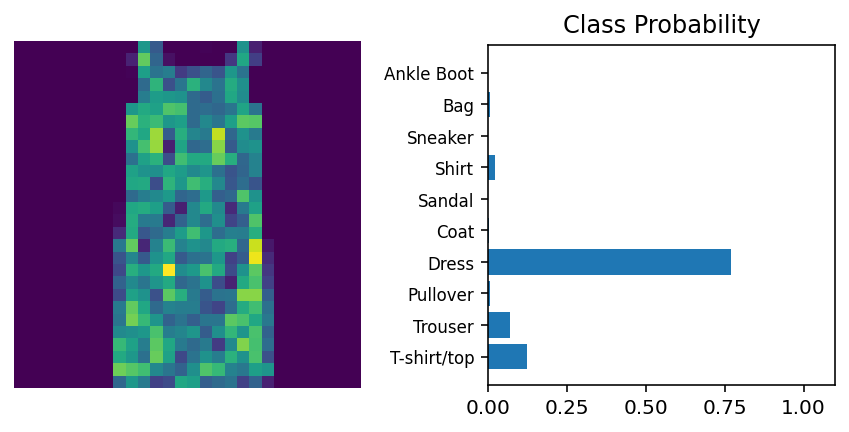

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]

# Convert 2D image to 1D vector
img = img.resize_(1, 784)

ps = torch.exp(model(img))

view_classify(img, ps, version='Fashion')